In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## 导入数据与预处理

### ERα_activity 

In [2]:
era = pd.read_excel('ERα_activity.xlsx')
era.head()

,SMILES,IC50_nM,pIC50
0,Oc1ccc2O[C@H]([C@H](Sc2c1)C3CCCC3)c4ccc(OCCN5C...,2.5,8.602060
1,Oc1ccc2O[C@H]([C@H](Sc2c1)C3CCCCCC3)c4ccc(OCCN...,7.5,8.124939
2,Oc1ccc(cc1)[C@H]2Sc3cc(O)ccc3O[C@H]2c4ccc(OCCN...,3.1,8.508638
3,Oc1ccc2O[C@H]([C@@H](CC3CCCCC3)Sc2c1)c4ccc(OCC...,3.9,8.408935
4,Oc1ccc2O[C@H]([C@@H](Cc3ccccc3)Sc2c1)c4ccc(OCC...,7.4,8.130768


In [3]:
erat = era.drop(columns=['SMILES'])
erapi = era['pIC50']
erapi.head()

0    8.602060
1    8.124939
2    8.508638
3    8.408935
4    8.130768
Name: pIC50, dtype: float64

In [4]:
era.info(),era.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1974 entries, 0 to 1973
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   SMILES   1974 non-null   object 
 1   IC50_nM  1974 non-null   float64
 2   pIC50    1974 non-null   float64
dtypes: float64(2), object(1)
memory usage: 46.4+ KB


(None,
             IC50_nM        pIC50
 count  1.974000e+03  1974.000000
 mean   9.910490e+03     6.586112
 std    1.055204e+05     1.423023
 min    4.600000e-02     2.455932
 25%    2.702500e+01     5.382154
 50%    2.625000e+02     6.580871
 75%    4.148125e+03     7.568235
 max    3.500000e+06    10.337242)

In [5]:
print('ERα_activity.xlsx 数据集中异常值个数为{}'.format(era.isnull().any().sum()))

ERα_activity.xlsx 数据集中异常值个数为0


### Molecular_Descriptor

In [6]:
mol = pd.read_excel('Molecular_Descriptor.xlsx',sheet_name='training')
mol_test = pd.read_excel('Molecular_Descriptor.xlsx',sheet_name='test')
mol.drop(columns=['SMILES'],inplace=True)
mol_test.drop(columns=['SMILES'],inplace=True)

In [7]:
mol.describe(),mol_test.describe()

(             nAcid        ALogP        ALogp2          AMR         apol  \
 count  1974.000000  1974.000000  1.974000e+03  1974.000000  1974.000000   
 mean      0.108409     1.110164  3.288495e+00   116.557106    60.626471   
 std       0.347900     1.434250  1.283292e+01    31.567455    19.449748   
 min       0.000000   -23.105000  3.600000e-07    54.067000    30.661930   
 25%       0.000000     0.376300  4.052598e-01    88.303700    44.432102   
 50%       0.000000     1.170950  1.560251e+00   114.837500    59.901376   
 75%       0.000000     1.948100  4.018823e+00   141.423650    74.421376   
 max       4.000000     5.181700  5.338410e+02   517.429400   359.662740   
 
         naAromAtom    nAromBond        nAtom   nHeavyAtom           nH  ...  \
 count  1974.000000  1974.000000  1974.000000  1974.000000  1974.000000  ...   
 mean     15.446809    16.189463    50.761905    28.112462    22.649443  ...   
 std       5.155854     5.635271    18.089182     8.073881    10.775491  .

In [8]:
print('Molecular_Descriptor.xlsx 数据集中异常值个数为{}'.format(mol.isnull().any().sum()))

Molecular_Descriptor.xlsx 数据集中异常值个数为0


## 特征选择

### 相关性矩阵

In [ ]:
# 设定一个阈值，考虑两个特征间有无相关性
# correlation coefficient (pearman)
mol_corr = mol.corr()
spearman_corr = mol.corr(method='spearman')
kendall_corr = mol.corr(method='kendall')
molt_cov = np.cov(mol.to_numpy())
#sns.heatmap(mol_corr, center=0, annot=True, cmap='YlGnBu') # take too much time

In [10]:
# 相关性算法：灰色关联、皮尔逊、秩相关、肯德尔、余弦、典型相关分析、Elasticsearch相关性
from sklearn.preprocessing import StandardScaler

ssc = StandardScaler()
fX = mol.values
fX_trans = ssc.fit_transform(fX)
fy = erapi.values
fX.shape,fX_trans.shape,fy.shape

((1974, 729), (1974, 729), (1974,))

In [11]:
# remove features with low variance
from sklearn.feature_selection import VarianceThreshold, SelectKBest, GenericUnivariateSelect
# sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel = VarianceThreshold(threshold=0)
sel.fit(fX)
# print('features whose variance equal to 0:')
sel_vars = sel.variances_
n_zero_var = 0
zero_var_cols = []
for i in range(len(sel_vars)):
    if sel_vars[i] == 0:
#         print('{} '.format(mol.columns[i]),end=' ')
        zero_var_cols.append(mol.columns[i])
        n_zero_var += 1
print('number of zero variance feature: ',n_zero_var)
fil_cols = list(set(mol.columns).difference(set(zero_var_cols)))
mol_fil = mol[fil_cols].copy()
mol_fil.info()

number of zero variance feature:  225
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1974 entries, 0 to 1973
Columns: 504 entries, ndsCH to MDEN-33
dtypes: float64(359), int64(145)
memory usage: 7.6 MB


In [12]:
ss = StandardScaler()
fX_fil = mol_fil.values
fX_fil_trans = ss.fit_transform(fX_fil)
fX_fil.shape,fX_fil_trans.shape

((1974, 504), (1974, 504))

In [39]:
# randomforest selection
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=2, max_depth=4,random_state=300)
rf_scores = []
# select individual feature and do cross-validation
for i in range(fX_fil.shape[1]):
    score = cross_val_score(rf,fX_fil[:, i:i+1], fy, scoring="r2", cv=ShuffleSplit(10, test_size=0.3))
    rf_scores.append((format(np.mean(score), '.3f'), mol_fil.columns[i]))
rf_columns = sorted(rf_scores, reverse=True)[:20]
rf_columns = [v[1] for v in rf_columns]
rf_columns

['BCUTc-1l',
 'SHsOH',
 'SsOH',
 'minHsOH',
 'maxHsOH',
 'maxsOH',
 'minsOH',
 'SssO',
 'MLFER_A',
 'MDEC-23',
 'WTPT-5',
 'maxssO',
 'MLogP',
 'MDEC-22',
 'nC',
 'nBase',
 'minssO',
 'LipoaffinityIndex',
 'minsssN',
 'BCUTc-1h']

In [ ]:
# information gain
from sklearn.feature_selection import mutual_info_regression
mu_imp = mutual_info_regression(molt[fil_cols].values,erapi.values)
fea_imp = pd.Series(mu_imp,index=molt[fil_cols].columns)
fea_imp.sort_values(ascending=False)[:20]
# fea_imp.plot(kind='barh',color='teal')

In [ ]:
# fisher score
from skfeature.function.similarity_based import fisher_score
fish_rank = fisher_score.fisher_score(fX,fy)
fea_imp = pd.Series(fish_rank, index=molt.columns)
fea_imp.sort_values(ascending=False)[:20]

In [11]:
# select top-20 best model from f_regression
from sklearn.feature_selection import f_regression
f_score = f_regression(fX_fil_trans,fy)[1]
f_best = SelectKBest(f_regression, k=20).fit_transform(fX_fil_trans,fy)
f_score_sorted = np.argsort(f_score)
mol_fil.columns[f_score_sorted[:20]]
# np.sort(f_score[1],)

Index(['MDEC-23', 'MLogP', 'LipoaffinityIndex', 'maxsOH', 'minsOH', 'nC',
       'nT6Ring', 'n6Ring', 'minsssN', 'BCUTp-1h', 'C2SP2', 'hmin', 'AMR',
       'SwHBa', 'maxsssN', 'MDEC-22', 'SP-5', 'SaaCH', 'CrippenLogP',
       'maxHsOH'],
      dtype='object')

In [ ]:
# lasso selection model
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
# try different alpha values to get 20 features
lasso_ = Lasso(alpha=0.1,random_state=100,max_iter=1000).fit(fX_fil_trans,fy)
lasso_coefs = (lasso_.coef_*100).tolist()
las_col = [i for i in range(len(lasso_coefs)) if lasso_coefs[i] != 0]
len(las_col),molt.columns[las_col]

In [196]:
# forward feature selection
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

lor = LogisticRegression()
lr = LinearRegression()
sfs = SequentialFeatureSelector(lr, 
                                n_features_to_select=20, 
                                direction='forward',
                                scoring='neg_mean_squared_error',
                                cv=5)
sfs.fit(fX_fil_trans,fy)
sfs_sup = sfs.get_support()
fea_sfs_lr = [i for i in range(len(sfs_sup)) if sfs_sup[i]]
mol_fil.columns[fea_sfs_lr]

Index(['minsssN', 'MLFER_A', 'SHCsats', 'maxsssCH', 'BCUTc-1l', 'BCUTp-1h',
       'C3SP2', 'mindsCH', 'WTPT-5', 'mindO', 'ATSc4', 'VC-6', 'maxHBd',
       'MDEC-24', 'ETA_dEpsilon_D', 'minsOH', 'C1SP2', 'maxHBint8', 'MAXDP2',
       'MDEC-23'],
      dtype='object')

## 回归模型选择

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

era_test = pd.read_excel('ERα_activity.xlsx',sheet_name='test')
fea_selected = mol_fil.columns[las_col]
train_X = mol[fea_selected].values
test_X = mol_test[fea_selected].values
train_y = fy
# X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y,test_size=0.3,shuffle=True, random_state=100)
# X_train.shape, X_test.shape, y_train.shape,y_test.shape

In [40]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

era_test = pd.read_excel('ERα_activity.xlsx',sheet_name='test')
train_X = mol[rf_columns].values
test_X = mol_test[rf_columns].values
train_y = fy

X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y,test_size=0.3,shuffle=True, random_state=100)
# X_train.shape, X_test.shape, y_train.shape,y_test.shape

In [41]:
# random forest
from sklearn.ensemble import RandomForestRegressor

rfreg = RandomForestRegressor(n_estimators=100,criterion='mse', random_state=0)
rfreg.fit(X_train, y_train)
y_pred = rfreg.predict(X_valid)

# evaluate
# print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('Mean Squared Error:', metrics.mean_squared_error(y_valid, y_pred))

Mean Squared Error: 0.5071129604219029


In [33]:
# AdaBoost regression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error

adareg = AdaBoostRegressor(n_estimators=100,random_state=0,loss='linear')
adareg.fit(X_train,y_train)
y_pred = adareg.predict(X_valid)
ada_mse = mean_squared_error(y_valid, y_pred)
print("AdaBoost mean square error = ", ada_mse)

AdaBoost mean square error =  0.8695915486388581


In [42]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

# Validation function
n_folds = 5
train = train_X
def mse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=100).get_n_splits(train_X)
    mse = -cross_val_score(model, train_X, train_y, scoring="neg_mean_squared_error", cv = kf)
#     rmse= np.sqrt(-cross_val_score(model, train_X, train_y, scoring="neg_mean_squared_error", cv = kf))
    return mse

# utilize individual model
lasso = make_pipeline(StandardScaler(), Lasso(alpha =0.005, random_state=100))

# ENet = make_pipeline(StandardScaler(), GridSearchCV(ElasticNet(random_state=100), param_grid=[
#     {'alpha':[0.0005], 'l1_ratio':[.8,.9]}
# ],cv=3,scoring='neg_mean_squared_error'))

ENet = make_pipeline(StandardScaler(), ElasticNet(max_iter=3000,alpha=0.0005, l1_ratio=.9, random_state=100))

KRR = GridSearchCV(KernelRidge(), param_grid=[
                {'alpha':[0.1,0.3,0.9,1.2,1.5,2.0], 'degree':[2,3,4],'coef0':[1,2.5]}
            ],cv=3,scoring='neg_mean_squared_error')

RFR = RandomForestRegressor(n_estimators=100,criterion='mse', random_state=0)

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [167]:
score = mse_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ElasticNet score: 1.1231 (0.3758)



In [43]:
score = mse_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = mse_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = mse_cv(RFR)
print("RandomForestRegressor score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = mse_cv(GBoost)
print("GBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
score = mse_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Lasso score: 1.2082 (0.3228)

ElasticNet score: 1.1826 (0.2922)



/Users/johnson/opt/anaconda3/envs/prac/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6881165486017835, tolerance: 0.28421570660568457
  model = cd_fast.enet_coordinate_descent(


RandomForestRegressor score: 1.0242 (0.2715)

GBoost score: 1.0484 (0.2236)

Kernel Ridge score: 1.3863 (0.3459)



In [44]:
score = mse_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

[22:49:39] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1631904775127/work/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:49:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1631904775127/work/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:49:43] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1631904775127/work/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only u

In [45]:
score = mse_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] 

In [46]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [47]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, RFR ,GBoost),
                                                 meta_model = lasso)

score = mse_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

/Users/johnson/opt/anaconda3/envs/prac/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5625698850615208, tolerance: 0.27636768397237726
  model = cd_fast.enet_coordinate_descent(
/Users/johnson/opt/anaconda3/envs/prac/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6635109995042967, tolerance: 0.22300474783561886
  model = cd_fast.enet_coordinate_descent(
/Users/johnson/opt/anaconda3/envs/prac/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.167478250879185, tolerance: 0.22944781411432516
  model = cd_fast.enet_coordinate_descent(
/Users/johnson/opt/anaconda3/

Stacking Averaged models score: 0.9748 (0.2622)


In [48]:
# stack model performance
stacked_averaged_models.fit(train_X, train_y)
stacked_train_pred = stacked_averaged_models.predict(train_X)
stacked_pred = stacked_averaged_models.predict(test_X)

/Users/johnson/opt/anaconda3/envs/prac/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.34815279282838674, tolerance: 0.3216047118705655
  model = cd_fast.enet_coordinate_descent(


In [124]:
one_x = test_X[0].reshape(1,-1)

In [49]:
model_xgb.fit(train_X, train_y)
xgb_train_pred = model_xgb.predict(train_X)
xgb_pred = model_xgb.predict(test_X)

model_lgb.fit(train, train_y)
lgb_train_pred = model_lgb.predict(train_X)
lgb_pred = model_lgb.predict(test_X)

print('Stack model MSE', mean_squared_error(train_y, stacked_train_pred))
print('XGBoost regression MSE',mean_squared_error(train_y, xgb_train_pred))
print('LightGBM regression MSE: ', mean_squared_error(train_y, lgb_train_pred))

[23:03:41] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1631904775127/work/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fractio

In [ ]:
import pickle
model_xgb = None
model_lgb = None
stacked_averaged_models = None
with open('xgb.model',mode='rb') as f:
    model_xgb = pickle.load(f)
with open('lgb.model',mode='rb') as f:
    model_lgb = pickle.load(f)
with open('stacked.model',mode='rb') as f:
    stacked_averaged_models = pickle.load(f)

In [50]:
# save regression model to file
import pickle
with open('xgb.model',mode='wb') as f:
    pickle.dump(model_xgb,f)
with open('stacked.model',mode='wb') as f:
    pickle.dump(stacked_averaged_models,f)
with open('lgb.model',mode='wb') as f:
    pickle.dump(model_lgb,f)

In [51]:
# TODO: find relatively small RMSE
print('MSE score on train data:', mean_squared_error(train_y,stacked_train_pred*0.70 +
               xgb_train_pred*0.25 + lgb_train_pred*0.05 ))

MSE score on train data: 0.10955402061292448


In [52]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15
# convert pIC50 to IC50_nM: 10^(-y+9)
result = np.power(10,(-ensemble + 9))

### 写入ERa文件

In [53]:
era_test['pIC50'] = ensemble
era_test['IC50_nM'] = result
era_test.to_excel('ERα_activity_bp.xlsx',sheet_name='test',index=False)
era_test_read = pd.read_excel('ERα_activity_bp.xlsx')
era_test_read.head()

,SMILES,IC50_nM,pIC50
0,COc1cc(OC)cc(\C=C\c2ccc(OS(=O)(=O)[C@@H]3C[C@@...,28.332603,7.547714
1,OC(=O)\C=C\c1ccc(cc1)C2=C(CCOc3ccccc23)c4ccc(O...,29.106274,7.536013
2,COc1ccc2C(=C(CCOc2c1)c3ccc(O)cc3)c4ccc(\C=C\C(...,74.512819,7.127769
3,OC(=O)\C=C\c1ccc(cc1)C2=C(CCOc3cc(F)ccc23)c4cc...,28.769850,7.541062
4,OC(=O)\C=C\c1ccc(cc1)C2=C(CCSc3cc(F)ccc23)c4cc...,31.298938,7.504470


## 分类模型选择

### 导入数据并划分

In [54]:
adm_train_src = pd.read_excel('ADMET.xlsx',sheet_name='training')
mol_test_src = pd.read_excel('Molecular_Descriptor.xlsx',sheet_name='test')
adm_test_src = pd.read_excel('ADMET.xlsx',sheet_name='test')
adm_train_src.describe(), mol_test_src.describe(),adm_test_src.describe()

(            Caco-2       CYP3A4         hERG          HOB           MN
 count  1974.000000  1974.000000  1974.000000  1974.000000  1974.000000
 mean      0.384498     0.740122     0.556738     0.257852     0.766971
 std       0.486600     0.438679     0.496896     0.437563     0.422868
 min       0.000000     0.000000     0.000000     0.000000     0.000000
 25%       0.000000     0.000000     0.000000     0.000000     1.000000
 50%       0.000000     1.000000     1.000000     0.000000     1.000000
 75%       1.000000     1.000000     1.000000     1.000000     1.000000
 max       1.000000     1.000000     1.000000     1.000000     1.000000,
            nAcid      ALogP      ALogp2         AMR        apol  naAromAtom  \
 count  50.000000  50.000000   50.000000   50.000000   50.000000   50.000000   
 mean    0.320000  -0.017308   28.055538  169.706782   94.093401   16.740000   
 std     0.471212   5.350495   57.209591   72.705179   53.824009    5.209136   
 min     0.000000 -13.821500   

In [55]:
Xtest = mol_test_src.drop(columns=['SMILES']).values
Xtest.shape

(50, 729)

In [56]:
# Xgboost、受限玻尔兹曼机(RBM)[DBN神经网络中的核心]、多层感知MLP、自组织映射SOM、lightBM
adm_train = adm_train_src.drop(columns=['SMILES'])
caco = adm_train['Caco-2']
cyp = adm_train['CYP3A4']
her = adm_train['hERG']
hob = adm_train['HOB']
mn = adm_train['MN']

In [86]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import xgboost as xgb
import lightgbm as lgb
from sklearn import metrics

def LR(X_train,y_train,X_test,y_test): 
    # Standardization
    ssc = StandardScaler()
    X_train_trans = ssc.fit_transform(X_train)
    X_test_trans = ssc.transform(X_test)
    lr = LogisticRegression()                                     
    lr.fit(X_train_trans,y_train)              
    y_prob = lr.predict_proba(X_test_trans)[:,1]                           
    y_pred = lr.predict(X_test_trans)                                      
    fpr_lr,tpr_lr,threshold_lr = metrics.roc_curve(y_test,y_prob)   
    auc_lr = metrics.auc(fpr_lr,tpr_lr)                             
    score_lr = metrics.accuracy_score(y_test,y_pred)                 
    print([score_lr,auc_lr])
    return lr, fpr_lr,tpr_lr,auc_lr,score_lr

def SVC_(X_train,y_train,X_test,y_test):
    # SVM with standardization
    ssc = StandardScaler()
    X_train_trans = ssc.fit_transform(X_train)
    X_test_trans = ssc.transform(X_test)
    kernelList = ['linear','rbf','sigmoid']
    svc = None
    auc_svc = -1
    score_svc = -1
    fpr_svc = None
    tpr_svc = None
    for kernel in kernelList:
        svc_tmp = SVC(kernel=kernel).fit(X_train_trans,y_train)

        # decision border distance
        y_prob = svc_tmp.decision_function(X_test_trans)
        y_pred = svc_tmp.predict(X_test_trans)
        # false positive, true positive
        fpr_svc_tmp,tpr_svc_tmp,threshold_svc_tmp = metrics.roc_curve(y_test,y_prob)
        # auc curve
        auc_svc_tmp = metrics.auc(fpr_svc_tmp,tpr_svc_tmp)
        score_svc_tmp = metrics.accuracy_score(y_test,y_pred)
        print([score_svc_tmp,auc_svc_tmp])    

        if not svc:
            svc = svc_tmp
        if auc_svc < auc_svc_tmp:
            auc_svc = auc_svc_tmp
            best_svc = svc
            score_svc = score_svc_tmp
            fpr_svc = fpr_svc_tmp
            tpr_svc = tpr_svc_tmp
    return svc, fpr_svc, tpr_svc, auc_svc, score_svc

def KNN(X_train,y_train,X_test,y_test):
    # KNN with standardization
    ssc = StandardScaler()
    X_train_trans = ssc.fit_transform(X_train)
    X_test_trans = ssc.transform(X_test)
    
    # find best K value
    score_K=[]
    KList=range(2,10)
    for k in KList:
        knn = KNeighborsClassifier(n_neighbors=k,weights='distance').fit(X_train_trans,y_train)
        score_K.append(knn.score(X_test_trans,y_test))
    print('K={}, get highest score={}'.format(KList[score_K.index(max(score_K))],max(score_K)))
    
    # knn = KNeighborsClassifier(n_neighbors=5,weights='uniform').fit(X_train_tran,y_train)
    knn = KNeighborsClassifier(n_neighbors=KList[score_K.index(max(score_K))],
                               weights='distance').fit(X_train_trans,y_train)

    y_prob = knn.predict_proba(X_test_trans)[:,1]                              
    y_pred = knn.predict(X_test_trans)                                       
    fpr_knn,tpr_knn,threshold_knn = metrics.roc_curve(y_test,y_prob)   
    auc_knn = metrics.auc(fpr_knn,tpr_knn)                              
    score_knn = metrics.accuracy_score(y_test,y_pred)
    print([score_knn,auc_knn])
    return knn, fpr_knn, tpr_knn, auc_knn, score_knn

def DTC(X_train,y_train,X_test,y_test):
    # decision tree
    dtc = tree.DecisionTreeClassifier()                         
    dtc.fit(X_train,y_train)                                       
    y_prob = dtc.predict_proba(X_test)[:,1]                          
    y_pred = dtc.predict(X_test)                                      
    fpr_dtc,tpr_dtc,threshod_dtc= metrics.roc_curve(y_test,y_prob)   
    score_dtc = metrics.accuracy_score(y_test,y_pred)                
    auc_dtc = metrics.auc(fpr_dtc,tpr_dtc) 
    print([score_dtc,auc_dtc])
    return dtc, fpr_dtc, tpr_dtc, auc_dtc, score_dtc

def RFC(X_train,y_train,X_test,y_test):
    # random forest classifier
    rfc = RandomForestClassifier()                                     
    rfc.fit(X_train,y_train)                                           
    y_prob = rfc.predict_proba(X_test)[:,1]               
    y_pred = rfc.predict(X_test)
    fpr_rfc,tpr_rfc,threshold_rfc = metrics.roc_curve(y_test,y_prob)    
    auc_rfc = metrics.auc(fpr_rfc,tpr_rfc)                
    score_rfc = metrics.accuracy_score(y_test,y_pred)                
    print([score_rfc,auc_rfc])
    return rfc, fpr_rfc, tpr_rfc, auc_rfc, score_rfc
    
def ADA(X_train,y_train,X_test,y_test):
    # AdaBoost Classifier
    # use weak classifier
    adaclf = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1),
    #     RandomForestClassifier(max_depth=1),
        n_estimators=100
    )
    adaclf.fit(X_train, y_train)
    y_pred = adaclf.predict(X_test)
    # print('adaboost confusion matrix:')
    conf_mat = confusion_matrix(y_test, y_pred)
    fpr_ada,tpr_ada,threshold_ada = metrics.roc_curve(y_test,y_pred)    
    auc_ada = metrics.auc(fpr_ada,tpr_ada)                             
    score_ada = metrics.accuracy_score(y_test,y_pred)  
    print('[{},{}]'.format(score_ada,auc_ada))
    return adaclf, fpr_ada, tpr_ada, auc_ada, score_ada

def XGB(X_train,y_train,X_test,y_test):
    # XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train) 
    dtest=xgb.DMatrix(X_test)

    params={'booster':'gbtree',
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth':4,
        'lambda': 10,
        'gamma':0.1,
        'subsample':0.75,
        'colsample_bytree':0.75,
        'min_child_weight':3,
        'eta': 0.025,
        'seed':10,
        'nthread':-1,
         'silent':1,
        'verbosity':0}

    watchlist = [(dtrain,'train')]
    bst=xgb.train(params,dtrain,num_boost_round=100,evals=watchlist)

    ypred=bst.predict(dtest)
    y_pred = (ypred >= 0.5)*1

    fpr_xgb,tpr_xgb,threshold_xgb = metrics.roc_curve(y_test,ypred)
    auc_xgb = metrics.auc(fpr_xgb,tpr_xgb)
    score_xgb = metrics.accuracy_score(y_test,y_pred)  
#     print ('AUC: %.4f' % metrics.roc_auc_score(y_test,ypred))
    print ('AUC: %.4f' % metrics.auc(fpr_xgb,tpr_xgb))
    print ('ACC: %.4f' % metrics.accuracy_score(y_test,y_pred))
#     print ('Precesion: %.4f' %metrics.precision_score(y_test,y_pred))
#     print ('Recall: %.4f' % metrics.recall_score(y_test,y_pred))
#     print ('F1-score: %.4f' %metrics.f1_score(y_test,y_pred))
    print(metrics.confusion_matrix(y_test,y_pred))
    return bst, fpr_xgb, tpr_xgb, auc_xgb, score_xgb
    
def LGBM(X_train,y_train,X_test,y_test):
    # LightGBM
    dtrain = lgb.Dataset(X_train, label=y_train) 
    dtest=lgb.Dataset(X_test,label=y_test)

    params = {'num_leaves': 60,
              'min_data_in_leaf': 20,
              'objective': 'binary',
              'max_depth': -1,
              'learning_rate': 0.03,
              "min_sum_hessian_in_leaf": 6,
              "boosting": "gbdt",
              "feature_fraction": 0.9,
              "bagging_freq": 1,
              "bagging_fraction": 0.8,
              "bagging_seed": 11,
              "lambda_l1": 0,
              'lambda_l2': 0.001,
              "verbosity": 0,
              "nthread": -1,
              'metric': {'binary_logloss', 'auc'},
              "random_state": 2021,
              }

    gbm = lgb.train(params,
                    dtrain,
                    num_boost_round=100,
                    valid_sets=dtest,
                    early_stopping_rounds=50)
    ypred=gbm.predict(X_test)
    y_pred = (ypred >= 0.5)*1

    fpr_gbm,tpr_gbm,threshold_gbm = metrics.roc_curve(y_test,ypred)
    auc_gbm = metrics.auc(fpr_gbm,tpr_gbm)
    score_gbm = metrics.accuracy_score(y_test,y_pred)  
#     print ('AUC: %.4f' % metrics.roc_auc_score(y_test,ypred))
    print ('AUC: %.4f' % metrics.auc(fpr_gbm,tpr_gbm))
    print ('ACC: %.4f' % metrics.accuracy_score(y_test,y_pred))
#     print ('Precesion: %.4f' %metrics.precision_score(y_test,y_pred))
#     print ('Recall: %.4f' % metrics.recall_score(y_test,y_pred))
#     print ('F1-score: %.4f' %metrics.f1_score(y_test,y_pred))
    print(metrics.confusion_matrix(y_test,y_pred))
    return gbm, fpr_gbm, tpr_gbm, auc_gbm, score_gbm


def plot_roc_curve(prs,name):
    # comparison between different approaches
    plt.style.use('bmh')
    plt.figure(figsize=(15,12))

    for k,v in prs.items():
        plt.plot(v[0],v[1],label=k)            

    plt.legend(loc='lower right',prop={'size':25})
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('{} ROC Curve'.format(name))
    plt.savefig('{}_roc_curve.jpg'.format(name))
    plt.show()

def clf_train(X,y,name):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=100)
    model_params = (X_train,y_train,X_test,y_test)
    
    lr, fpr_lr,tpr_lr,auc_lr,score_lr = LR(*model_params)
    svc, fpr_svc ,tpr_svc,auc_svc,score_svc = SVC_(*model_params)
    knn, fpr_knn,tpr_knn,auc_knn,score_knn = KNN(*model_params)
    dtc, fpr_dtc,tpr_dtc,auc_dtc,score_dtc = DTC(*model_params)
    rfc, fpr_rfc,tpr_rfc,auc_rfc,score_rfc = RFC(*model_params)
    ada, fpr_ada,tpr_ada,auc_ada,score_ada = ADA(*model_params)
    bst, fpr_xgb,tpr_xgb,auc_xgb,score_xgb = XGB(*model_params)
#     gbm, fpr_gbm,tpr_gbm,auc_gbm,score_gbm = LGBM(*model_params)
    
    ret = {
        'lr':(fpr_lr,tpr_lr,auc_lr,lr), 
        'svc':(fpr_svc,tpr_svc,auc_svc,svc),
        'knn':(fpr_knn,tpr_knn,auc_knn,knn),
        'dtc':(fpr_dtc,tpr_dtc,auc_dtc,dtc),
        'rfc':(fpr_rfc,tpr_rfc,auc_rfc,rfc),
        'ada':(fpr_ada,tpr_ada,auc_ada,ada),
        'xgb':(fpr_xgb,tpr_xgb,auc_xgb,bst),
#         'gbm':(fpr_gbm,tpr_gbm,auc_gbm,gbm)
    }
    
    return ret

def clf_predict(ret,Xtest,name):
    plot_roc_curve(ret,name)
    # AUC score comparison
    best_mn = ''
    best_m = None
    highest_score = -1
    for k,v in ret.items():
        if v[-2] > highest_score:
            highest_score = v[-2]
            best_mn = k
            best_m = v[-1]
    print('{} get highest AUC score({}), applied to compound: {}'.format(best_mn,highest_score,name))

    if best_mn == 'xgb':
        Dtest = xgb.DMatrix(Xtest)
        y_final_test = (best_m.predict(Dtest) >= 0.5) * 1
    elif best_mn == 'gbm':
        y_final_test = (best_m.predict(Xtest) >= 0.5) * 1
    else:
        y_final_test = best_m.predict(Xtest)
    best_item = {name:(best_mn,best_m)}
    return y_final_test, best_item

### 比较各个分类器的效果

In [113]:
compound_best_items = []

In [58]:
compound_names = ['Caco-2','CYP3A4','hERG','HOB']
compound_rets = []
compound_best_items = []

# training different model in different compounds
for name in compound_names:
    compound_rets.append(clf_train(fX, adm_train[name].values,name))

/Users/johnson/opt/anaconda3/envs/prac/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[0.9008097165991903, 0.9603149327671621]
[0.8825910931174089, 0.9493984430290163]
[0.9149797570850202, 0.9752653927813164]
[0.8299595141700404, 0.896302193913659]
K=9, get highest score=0.8846153846153846
[0.8846153846153846, 0.9538305024769993]
[0.8704453441295547, 0.8589702760084925]
[0.9089068825910931, 0.9710014154281671]
[0.9008097165991903,0.8970806794055203]
[0]	train-auc:0.92612
[1]	train-auc:0.93984
[2]	train-auc:0.94284
[3]	train-auc:0.94570
[4]	train-auc:0.95621
[5]	train-auc:0.95807
[6]	train-auc:0.95848
[7]	train-auc:0.95851
[8]	train-auc:0.95967
[9]	train-auc:0.96012
[10]	train-auc:0.96082
[11]	train-auc:0.96081
[12]	train-auc:0.96086
[13]	train-auc:0.96123
[14]	train-auc:0.96130
[15]	train-auc:0.96232
[16]	train-auc:0.96232
[17]	train-auc:0.96243
[18]	train-auc:0.96268
[19]	train-auc:0.96290
[20]	train-auc:0.96315
[21]	train-auc:0.96524
[22]	train-auc:0.96526
[23]	train-auc:0.96570
[24]	train-auc:0.96672
[25]	train-auc:0.96696
[26]	train-auc:0.96679
[27]	train-auc:0.9675

/Users/johnson/opt/anaconda3/envs/prac/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[0.9412955465587044, 0.9737442669443644]
[0.9473684210526315, 0.977887576717701]
[0.917004048582996, 0.9655241176079586]
K=5, get highest score=0.9311740890688259
[0.9311740890688259, 0.9601843440498083]
[0.9089068825910931, 0.8838433075576628]
[0.9392712550607287, 0.977643852613387]
[0.9493927125506073,0.9274034520195865]
[0]	train-auc:0.95052
[1]	train-auc:0.95790
[2]	train-auc:0.96359
[3]	train-auc:0.96736
[4]	train-auc:0.96968
[5]	train-auc:0.97173
[6]	train-auc:0.97577
[7]	train-auc:0.97768
[8]	train-auc:0.98074
[9]	train-auc:0.98033
[10]	train-auc:0.98045
[11]	train-auc:0.98049
[12]	train-auc:0.98136
[13]	train-auc:0.98161
[14]	train-auc:0.98178
[15]	train-auc:0.98203
[16]	train-auc:0.98259
[17]	train-auc:0.98290
[18]	train-auc:0.98308
[19]	train-auc:0.98313
[20]	train-auc:0.98302
[21]	train-auc:0.98371
[22]	train-auc:0.98359
[23]	train-auc:0.98398
[24]	train-auc:0.98415
[25]	train-auc:0.98451
[26]	train-auc:0.98450
[27]	train-auc:0.98486
[28]	train-auc:0.98494
[29]	train-auc:0.9

/Users/johnson/opt/anaconda3/envs/prac/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[0.8744939271255061, 0.9500565084430261]
[0.8947368421052632, 0.9647985640207418]
[0.8967611336032388, 0.9389542614014093]
K=8, get highest score=0.8927125506072875
[0.8927125506072875, 0.9496576253157825]
[0.8360323886639676, 0.8330175508575988]
[0.888663967611336, 0.968413442361388]
[0.9089068825910931,0.9059466826219919]
[0]	train-auc:0.91275
[1]	train-auc:0.94680
[2]	train-auc:0.95532
[3]	train-auc:0.95631
[4]	train-auc:0.95835
[5]	train-auc:0.96029
[6]	train-auc:0.96072
[7]	train-auc:0.96074
[8]	train-auc:0.96071
[9]	train-auc:0.96049
[10]	train-auc:0.96207
[11]	train-auc:0.96250
[12]	train-auc:0.96437
[13]	train-auc:0.96535
[14]	train-auc:0.96575
[15]	train-auc:0.96555
[16]	train-auc:0.96604
[17]	train-auc:0.96646
[18]	train-auc:0.96719
[19]	train-auc:0.96730
[20]	train-auc:0.96807
[21]	train-auc:0.96823
[22]	train-auc:0.96831
[23]	train-auc:0.96846
[24]	train-auc:0.96862
[25]	train-auc:0.96884
[26]	train-auc:0.96893
[27]	train-auc:0.96910
[28]	train-auc:0.96942
[29]	train-auc:0.

/Users/johnson/opt/anaconda3/envs/prac/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[0.8704453441295547, 0.8999289772727272]
[0.8643724696356275, 0.9184895833333333]
[0.8218623481781376, 0.8114820075757577]
K=6, get highest score=0.8522267206477733
[0.8522267206477733, 0.8937855113636364]
[0.8299595141700404, 0.7608901515151515]
[0.8805668016194332, 0.9342092803030303]
[0.8704453441295547,0.7999053030303032]
[0]	train-auc:0.86384
[1]	train-auc:0.87535
[2]	train-auc:0.88137
[3]	train-auc:0.89274
[4]	train-auc:0.90090
[5]	train-auc:0.90412
[6]	train-auc:0.90521
[7]	train-auc:0.91473
[8]	train-auc:0.91635
[9]	train-auc:0.91704
[10]	train-auc:0.92189
[11]	train-auc:0.92301
[12]	train-auc:0.92388
[13]	train-auc:0.93038
[14]	train-auc:0.92981
[15]	train-auc:0.93156
[16]	train-auc:0.93162
[17]	train-auc:0.93173
[18]	train-auc:0.93663
[19]	train-auc:0.93717
[20]	train-auc:0.93742
[21]	train-auc:0.93862
[22]	train-auc:0.93839
[23]	train-auc:0.93835
[24]	train-auc:0.93884
[25]	train-auc:0.93892
[26]	train-auc:0.93885
[27]	train-auc:0.94040
[28]	train-auc:0.94051
[29]	train-auc:

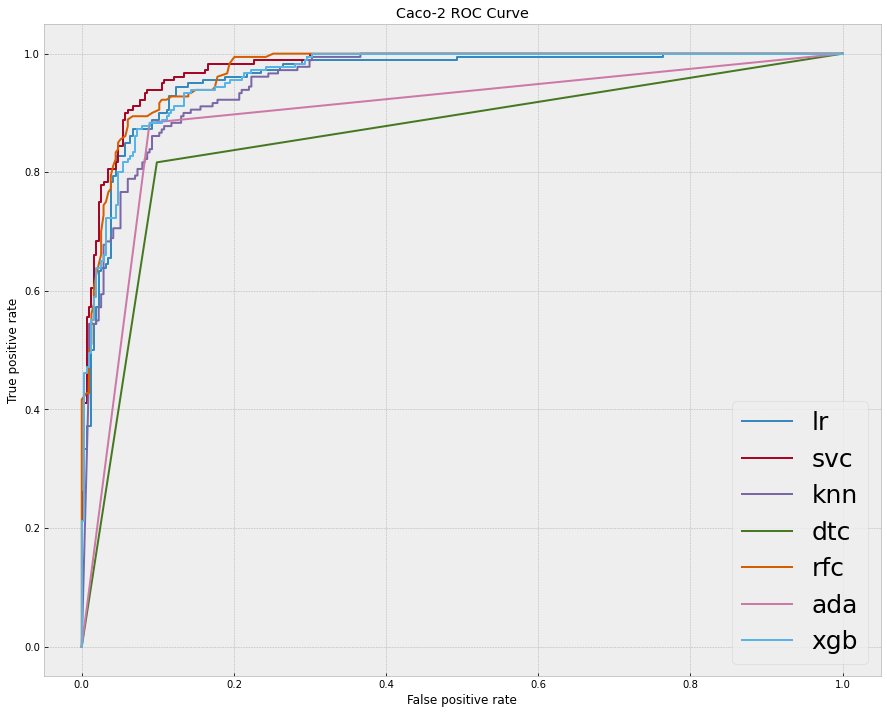

svc get highest AUC score(0.9752653927813164), applied to compound: Caco-2


In [114]:
adm_test_src[compound_names[0]],best_item = clf_predict(compound_rets[0],Xtest,compound_names[0])
compound_best_items.append(best_item)

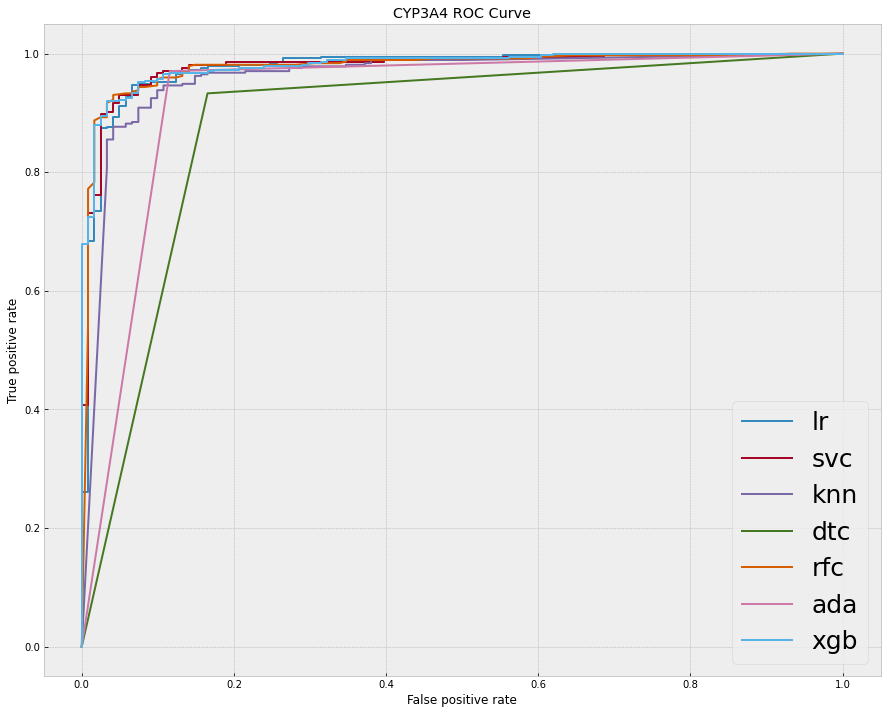

xgb get highest AUC score(0.9808787361797354), applied to compound: CYP3A4


In [115]:
adm_test_src[compound_names[1]],best_item = clf_predict(compound_rets[1],Xtest,compound_names[1])
compound_best_items.append(best_item)

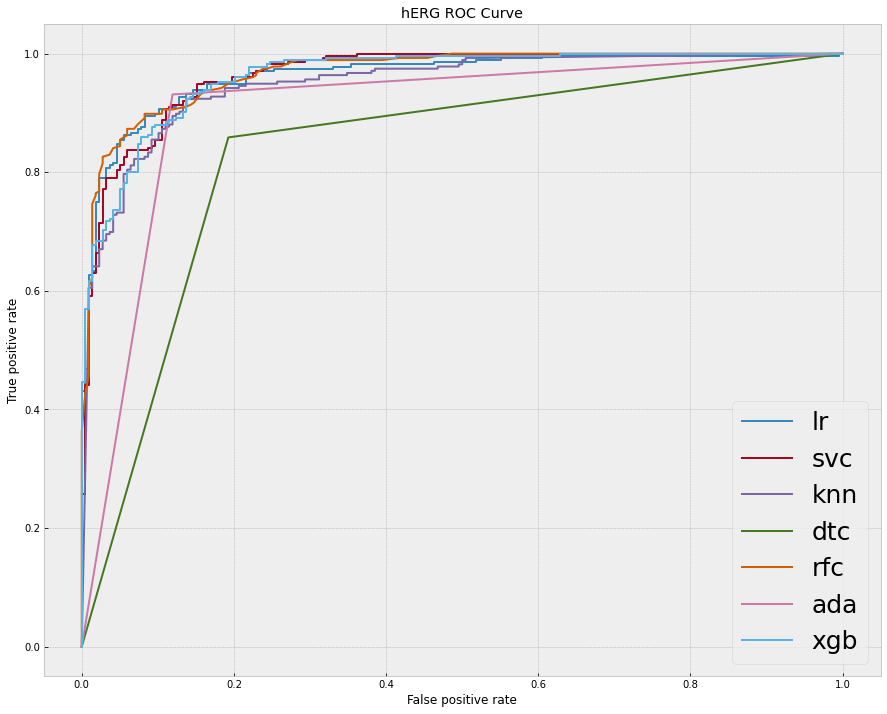

rfc get highest AUC score(0.968413442361388), applied to compound: hERG


In [116]:
adm_test_src[compound_names[2]],best_item = clf_predict(compound_rets[2],Xtest,compound_names[2])
compound_best_items.append(best_item)

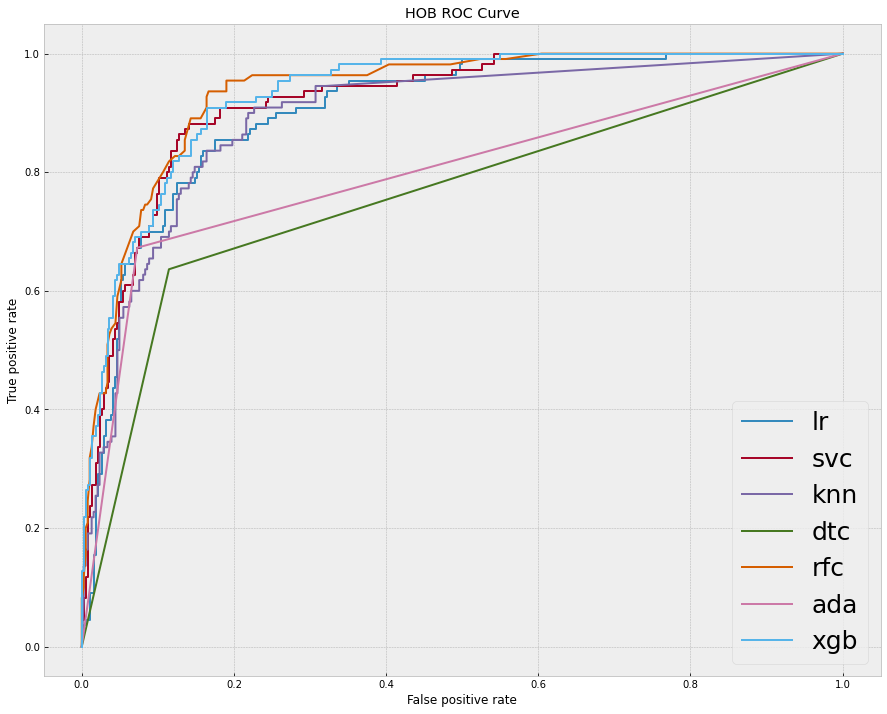

rfc get highest AUC score(0.9342092803030303), applied to compound: HOB


In [117]:
adm_test_src[compound_names[3]],best_item =  clf_predict(compound_rets[3],Xtest,compound_names[3])
compound_best_items.append(best_item)

### 对 MN 化合物做特殊处理

In [118]:
# 样本不均衡，随机采样 3次然后综合最后的预测结果
mn.value_counts(),mn.value_counts() / len(mn)

(1    1514
 0     460
 Name: MN, dtype: int64,
 1    0.766971
 0    0.233029
 Name: MN, dtype: float64)

In [119]:
from imblearn.over_sampling import SMOTE
from collections import Counter

smo = SMOTE(sampling_strategy=0.5,random_state=100)
fX_smo, y_mn_smo = smo.fit_resample(fX,adm_train['MN'])
fX_smo.shape, y_mn_smo.shape

((2271, 729), (2271,))

In [120]:
mn_ret = clf_train(fX_smo,y_mn_smo,'MN')
compound_names.append('MN')
compound_rets.append(mn_ret)

[0.9401408450704225, 0.984555599840574]


/Users/johnson/opt/anaconda3/envs/prac/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[0.9454225352112676, 0.980256789842282]
[0.926056338028169, 0.9833029664635882]
[0.829225352112676, 0.8978107384843137]
K=2, get highest score=0.9524647887323944
[0.9524647887323944, 0.9612466548995047]
[0.9577464788732394, 0.9514889255821898]
[0.9753521126760564, 0.9946122530319421]
[0.9665492957746479,0.9623213573990775]
[0]	train-auc:0.89282
[1]	train-auc:0.95801
[2]	train-auc:0.96062
[3]	train-auc:0.96252
[4]	train-auc:0.97094
[5]	train-auc:0.97277
[6]	train-auc:0.97131
[7]	train-auc:0.97089
[8]	train-auc:0.97134
[9]	train-auc:0.97361
[10]	train-auc:0.97336
[11]	train-auc:0.97296
[12]	train-auc:0.97379
[13]	train-auc:0.97375
[14]	train-auc:0.97437
[15]	train-auc:0.97786
[16]	train-auc:0.97997
[17]	train-auc:0.98049
[18]	train-auc:0.98019
[19]	train-auc:0.98191
[20]	train-auc:0.98461
[21]	train-auc:0.98528
[22]	train-auc:0.98637
[23]	train-auc:0.98638
[24]	train-auc:0.98815
[25]	train-auc:0.98789
[26]	train-auc:0.98806
[27]	train-auc:0.98908
[28]	train-auc:0.98945
[29]	train-auc:0.9

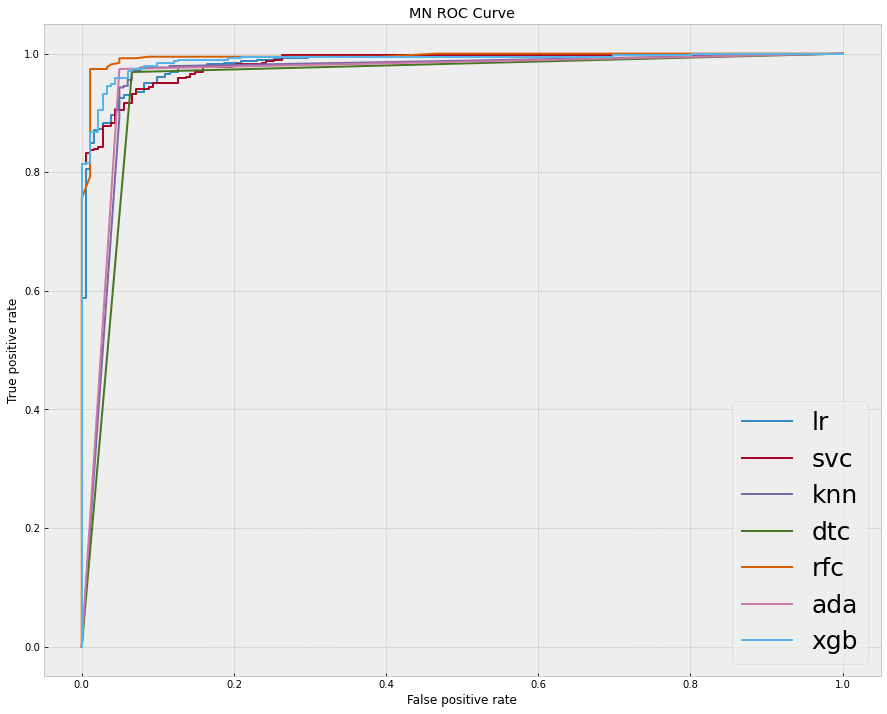

rfc get highest AUC score(0.9946122530319421), applied to compound: MN


In [121]:
adm_test_src['MN'],best_item = clf_predict(mn_ret,Xtest,'MN')
compound_best_items.append(best_item)

In [122]:
compound_best_items

[{'Caco-2': ('svc', SVC(kernel='linear'))},
 {'CYP3A4': ('xgb', <xgboost.core.Booster at 0x7ff1d88ebfd0>)},
 {'hERG': ('rfc', RandomForestClassifier())},
 {'HOB': ('rfc', RandomForestClassifier())},
 {'MN': ('rfc', RandomForestClassifier())}]

### 写入文件的 test sheet

In [67]:
adm_test_src

,SMILES,Caco-2,CYP3A4,hERG,HOB,MN
0,COc1cc(OC)cc(\C=C\c2ccc(OS(=O)(=O)[C@@H]3C[C@@...,0,1,1,0,1
1,OC(=O)\C=C\c1ccc(cc1)C2=C(CCOc3ccccc23)c4ccc(O...,0,1,1,0,1
2,COc1ccc2C(=C(CCOc2c1)c3ccc(O)cc3)c4ccc(\C=C\C(...,0,1,1,0,1
3,OC(=O)\C=C\c1ccc(cc1)C2=C(CCOc3cc(F)ccc23)c4cc...,0,1,1,0,1
4,OC(=O)\C=C\c1ccc(cc1)C2=C(CCSc3cc(F)ccc23)c4cc...,0,1,1,0,1
5,CC(=O)\C=C\c1ccc(cc1)C2=C(CCOc3cc(F)ccc23)c4cc...,0,1,1,0,1
6,Oc1ccc(cc1)C2=C(c3ccc(\C=C\c4ccccc4)cc3)c5ccc(...,0,1,1,0,0
7,Oc1ccc(cc1)C2=C(c3ccc(\C=C\C(=O)c4ccccc4)cc3)c...,0,1,1,0,1
8,OC(=O)\C=C\C=C\c1ccc(cc1)C2=C(CCOc3cc(F)ccc23)...,0,1,1,0,1
9,CCN(CC)C(=O)\C=C\c1ccc(cc1)C2=C(CCOc3cc(F)ccc2...,0,1,1,0,1


In [68]:
adm_test_src.to_excel('ADMET_bp.xlsx',sheet_name='test',index=False)
adm_read_src = pd.read_excel('ADMET_bp.xlsx')
adm_read_src.head()

,SMILES,Caco-2,CYP3A4,hERG,HOB,MN
0,COc1cc(OC)cc(\C=C\c2ccc(OS(=O)(=O)[C@@H]3C[C@@...,0,1,1,0,1
1,OC(=O)\C=C\c1ccc(cc1)C2=C(CCOc3ccccc23)c4ccc(O...,0,1,1,0,1
2,COc1ccc2C(=C(CCOc2c1)c3ccc(O)cc3)c4ccc(\C=C\C(...,0,1,1,0,1
3,OC(=O)\C=C\c1ccc(cc1)C2=C(CCOc3cc(F)ccc23)c4cc...,0,1,1,0,1
4,OC(=O)\C=C\c1ccc(cc1)C2=C(CCSc3cc(F)ccc23)c4cc...,0,1,1,0,1


## 寻找分子描述符的范围

In [69]:
d_adm = pd.read_excel('ADMET.xlsx')
d_mol = pd.read_excel('Molecular_Descriptor.xlsx',sheet_name='training')
d_pic = pd.read_excel('ERα_activity.xlsx', sheet_name='training')
d_mol.drop(columns=['SMILES'],inplace=True)
d_adm.drop(columns=['SMILES'],inplace=True)
cols = d_adm.columns.to_list()
d_adm.head()

,Caco-2,CYP3A4,hERG,HOB,MN
0,0,1,1,0,0
1,0,1,1,0,0
2,0,1,1,0,1
3,0,1,1,0,0
4,0,1,1,0,0


In [79]:
d_adm['pIC50'] = d_pic['pIC50']
d_adm['dis'] = d_adm.apply(lambda x: x[cols[1]] + x[cols[2]] +x[cols[4]] - x[cols[0]] - x[cols[3]],axis=1)
d_fil = d_adm[d_adm['dis'] <= 0]
suit_index = d_fil.sort_values(by='pIC50',ascending=False).index[0]
suit_sample = d_mol[rf_columns].iloc[suit_index]
suit_src_admet = d_adm.iloc[suit_index]
suit_sample,suit_src_admet

(BCUTc-1l             -0.361399
 SHsOH                 1.141009
 SsOH                 18.821359
 minHsOH               0.570504
 maxHsOH               0.570504
 maxsOH                9.410680
 minsOH                9.410680
 SssO                  0.000000
 MLFER_A               1.089000
 MDEC-23              21.169006
 WTPT-5                0.000000
 maxssO                0.000000
 MLogP                 3.220000
 MDEC-22              12.197701
 nC                   18.000000
 nBase                 0.000000
 minssO                0.000000
 LipoaffinityIndex     7.330748
 minsssN               0.000000
 BCUTc-1h              0.073888
 Name: 65, dtype: float64,
 Caco-2    1.000000
 CYP3A4    0.000000
 hERG      0.000000
 HOB       0.000000
 MN        1.000000
 pIC50     9.481486
 dis       0.000000
 Name: 65, dtype: float64)

In [123]:
compound_best_items

[{'Caco-2': ('svc', SVC(kernel='linear'))},
 {'CYP3A4': ('xgb', <xgboost.core.Booster at 0x7ff1d88ebfd0>)},
 {'hERG': ('rfc', RandomForestClassifier())},
 {'HOB': ('rfc', RandomForestClassifier())},
 {'MN': ('rfc', RandomForestClassifier())}]

In [130]:
# x2 + x3 + x5 - x1 - x4 <= 0
for item in compound_best_items:
    item = list(item.values())[0]
    print('{} : {}'.format(item[0], item[1]))

svc : SVC(kernel='linear')
xgb : <xgboost.core.Booster object at 0x7ff1d88ebfd0>
rfc : RandomForestClassifier()
rfc : RandomForestClassifier()
rfc : RandomForestClassifier()
